# Visualize conf vs HOTA results

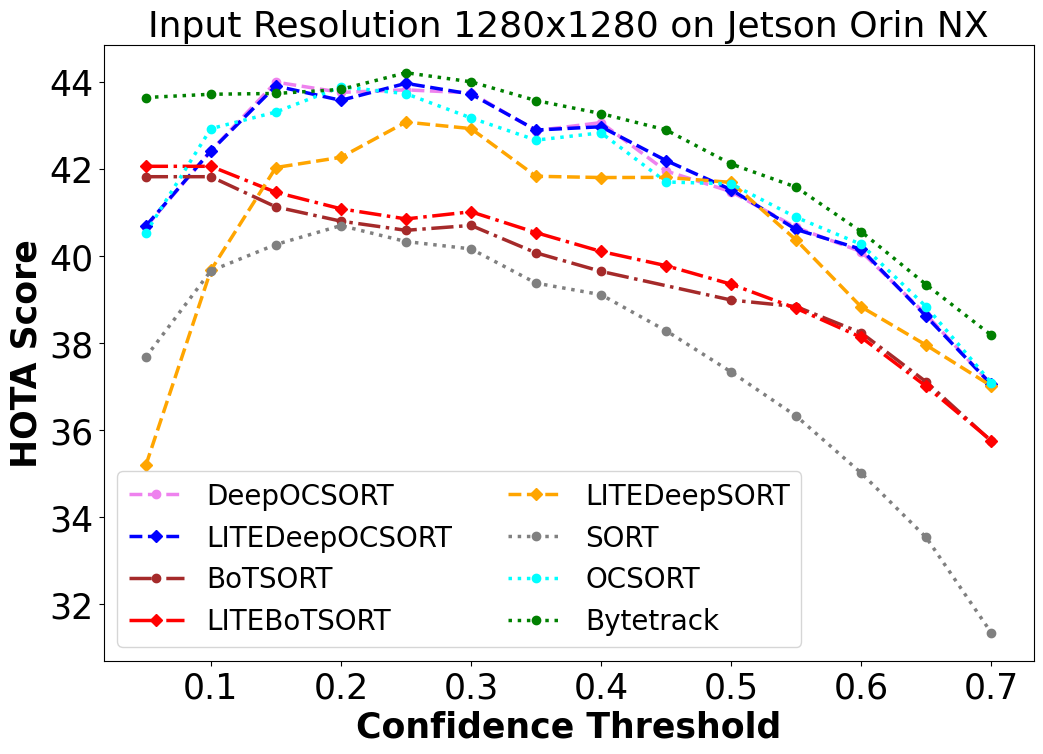

In [14]:
import os
import re
import matplotlib.pyplot as plt

imgsz = 1280

# Define the directory path
base_dir = f'MOT17-train_{imgsz}_evaluated'

# List of trackers with their line styles and colors
tracker_styles = {
    "DeepOCSORT": {"line_style": '--', "color": 'violet'},   # Purple
    "LITEDeepOCSORT": {"line_style": '--', "color": 'b'},  # Orange
    "BoTSORT": {"line_style": '-.', "color": 'brown'},          # Red
    "LITEBoTSORT": {"line_style": '-.', "color": 'r'},   # Brown
    "LITEDeepSORT": {"line_style": '--', "color": 'orange'},   # Gray
    "SORT": {"line_style": ':', "color": 'gray'},               # Blue
    "OCSORT": {"line_style": ':', "color": 'cyan'},        # Cyan
    "Bytetrack": {"line_style": ':', "color": 'g'},        # Green
    # "StrongSORT": {"line_style": ':', "color": 'magenta'}, # Magenta
}

# Dictionary to store confidence values and HOTA scores for each tracker
tracker_data = {key: {"conf": [], "hota": []} for key in tracker_styles.keys()}

# Loop through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue
    
    # Check if the folder matches any of the tracker names
    for tracker in tracker_styles.keys():
        if re.match(rf'^{tracker}__input_{imgsz}__conf_\d+\.\d+$', folder):
            # Extract confidence value from the folder name
            match = re.search(r'conf_(\d+\.\d+)', folder)
            if match:
                conf = float(match.group(1))
                
                # Path to pedestrian_summary.txt
                summary_file = os.path.join(folder_path, 'pedestrian_summary.txt')
                
                # Check if the file exists
                if os.path.isfile(summary_file):
                    # Read the file and get the HOTA value
                    with open(summary_file, 'r') as f:
                        f.readline()  # Skip the header line
                        line = f.readline().strip()  # Read the values line
                        
                        # Split the line by spaces and take the first value as HOTA
                        try:
                            hota = float(line.split()[0])
                            # Append confidence and HOTA to the tracker's lists
                            tracker_data[tracker]["conf"].append(conf)
                            tracker_data[tracker]["hota"].append(hota)
                        except ValueError as e:
                            print(f"Error reading HOTA in {summary_file}: {e}")
            break  # Stop checking other trackers if a match is found

# Plot HOTA vs. Confidence for all trackers in one plot
plt.figure(figsize=(12, 8))

# Plot each tracker with its specified line style and color
for tracker, data in tracker_data.items():
    if data["conf"] and data["hota"]:  # Check if there's data to plot
        # Sort data by confidence values
        sorted_data = sorted(zip(data["conf"], data["hota"]))
        conf_values, hota_values = zip(*sorted_data)

        # Get line style and color from the tracker styles
        line_style = tracker_styles[tracker]["line_style"]
        color = tracker_styles[tracker]["color"]
        if 'LITE' in tracker:
            marker = 'D'
        else:
            marker = 'o'
        plt.plot(conf_values, hota_values, marker=marker, linestyle=line_style, color=color, label=tracker, linewidth=2.5)
        # plt.yticks([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

# Add labels, title, legend, and grid
plt.xlabel('Confidence Threshold', fontsize=25, weight='bold')
plt.ylabel('HOTA Score', fontsize=25, weight='bold')
plt.xticks(fontsize=25)  # Adjust x-axis font size
plt.yticks(fontsize=25)  # Adjust y-axis font size
plt.title(f'Input Resolution {imgsz}x{imgsz} on Jetson Orin NX', fontsize=26)
plt.legend(fontsize=20, ncol=2)
# save the plot
plt.savefig(f'hota_vs_conf_input_{imgsz}_MOT17.png')
plt.show()

# Visualize conf vs FPS results

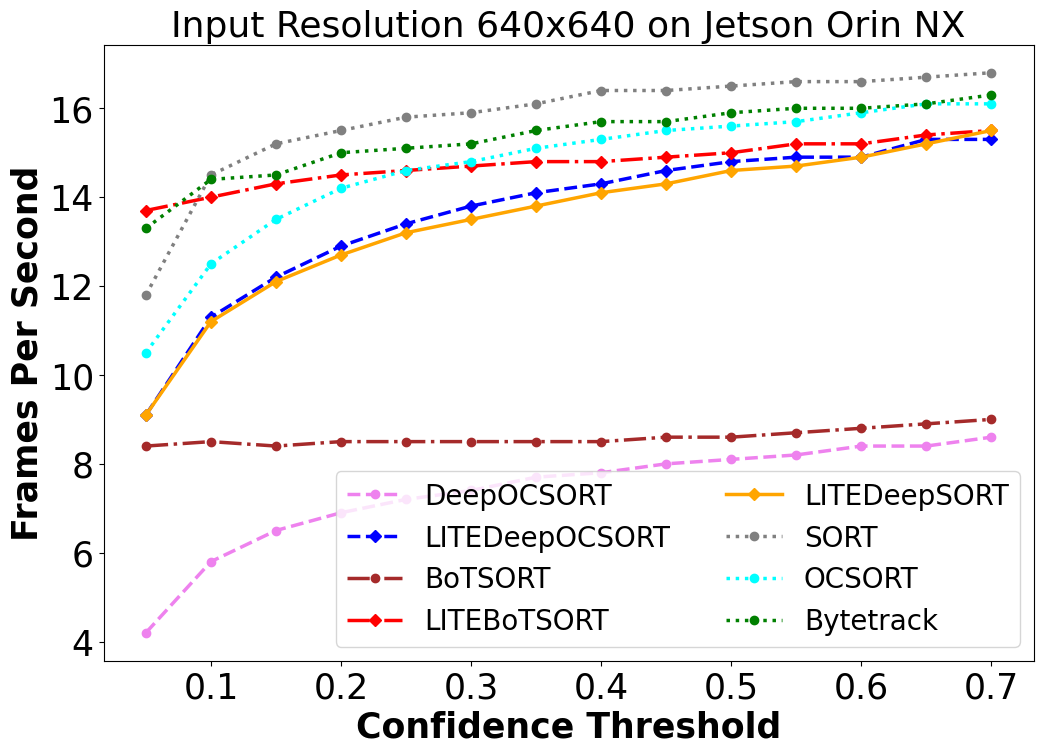

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

imgsz = 640

# Load the CSV file
file_path = f"MOT17-FPS_{imgsz}/MOT17-02-FRCNN/fps.csv"
data = pd.read_csv(file_path)

# Define styles for each tracker
tracker_styles = {
    "DeepOCSORT": {"line_style": '--', "color": 'violet'},  
    "LITEDeepOCSORT": {"line_style": '--', "color": 'b'},  
    "BoTSORT": {"line_style": '-.', "color": 'brown'},       
    "LITEBoTSORT": {"line_style": '-.', "color": 'r'},       
    "LITEDeepSORT": {"line_style": '-', "color": 'orange'}, 
    "SORT": {"line_style": ':', "color": 'gray'},             
    "OCSORT": {"line_style": ':', "color": 'cyan'},           
    "Bytetrack": {"line_style": ':', "color": 'g'},           
}

# Plotting
plt.figure(figsize=(12, 8))

# Plot each tracker using the specified line style and color, in the order of tracker_styles
for tracker, style in tracker_styles.items():
    tracker_data = data[data['tracker_name'] == tracker]
    sorted_data = tracker_data.sort_values(by='conf')
    
    line_style = style["line_style"]
    color = style["color"]
    marker = 'D' if 'LITE' in tracker else 'o'

    # Plot confidence vs FPS
    plt.plot(
        sorted_data['conf'], 
        sorted_data['FPS'], 
        marker=marker, 
        linestyle=line_style, 
        color=color, 
        label=tracker, 
        linewidth=2.5
    )

# Add labels, title, and legend in specified order
plt.xlabel('Confidence Threshold', fontsize=25, weight='bold')
plt.ylabel('Frames Per Second', fontsize=25, weight='bold')
plt.title(f'Input Resolution {imgsz}x{imgsz} on Jetson Orin NX', fontsize=26)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20, ncol=2)
# save the plot
plt.savefig(f'fps_vs_conf_input_{imgsz}_MOT17.png')
plt.show()


# Get HOTA and other metrics to make results table

In [12]:
import os

# Directory where the trackers are stored
base_dir = '/home/hbai/LITE/results/MOT17-train_1280_evaluated/'

# Initialize a dictionary to store the results for each tracker
metrics_summary = {}

# Loop through each tracker folder in the base directory
for tracker_folder in os.listdir(base_dir):
    # Construct the path to pedestrian_summary.txt
    if "0.25" not in tracker_folder:
        continue
    summary_file_path = os.path.join(base_dir, tracker_folder, 'pedestrian_summary.txt')
    
    # Check if the file exists
    if os.path.isfile(summary_file_path):
        with open(summary_file_path, 'r') as f:
            # Read the data line by line
            lines = f.readlines()
            
            # Header line for metrics (assuming it's the first line)
            headers = lines[0].strip().split()
            
            # Values line (assuming it's the second line)
            values = lines[1].strip().split()
            
            # Convert values to floats for easier manipulation if needed
            values = list(map(float, values))
            
            # Create a dictionary for the metrics in this file
            metrics = dict(zip(headers, values))
            
            # Extract the required metrics
            metrics_summary[tracker_folder] = {
                'HOTA': metrics['HOTA'],
                'IDF1': metrics['IDF1'],
                'MOTA': metrics['MOTA'],
                'AssA': metrics['AssA'],
                'DetA': metrics['DetA']
            }

# Print the extracted metrics
for tracker, metrics in metrics_summary.items():
    print(f"{tracker.split('__')[0].rjust(20, ' ')}: & {metrics['HOTA']:.1f} & {metrics['IDF1']:.1f} & {metrics['MOTA']:.1f} & {metrics['AssA']:.1f} & {metrics['DetA']:.1f}")


         LITEBoTSORT: & 40.9 & 46.3 & 41.1 & 42.0 & 40.1
        LITEDeepSORT: & 43.1 & 50.8 & 41.5 & 43.5 & 43.3
      LITEDeepOCSORT: & 44.0 & 51.0 & 43.3 & 45.9 & 42.5
          DeepOCSORT: & 43.8 & 51.1 & 43.3 & 45.7 & 42.5
                SORT: & 40.3 & 44.5 & 42.2 & 38.8 & 42.7
              OCSORT: & 43.7 & 51.0 & 43.4 & 45.4 & 42.5
             BoTSORT: & 40.6 & 45.8 & 41.1 & 41.5 & 40.1
           Bytetrack: & 44.2 & 52.0 & 43.5 & 46.1 & 42.9
